In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
from torch import nn, optim
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"


In [2]:
# ----- Data -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

num_classes = 2
print("class_to_idx:", train_dataset.class_to_idx)

# ----- Backbone (torchvision ViT) -----
model = models.vit_b_16(pretrained=True).to(device)
for p in model.parameters():
    p.requires_grad = False

# penultimate feature size
feat_dim_backbone = model.heads.head.in_features

# helper to extract CLS features (torchvision)
def vit_cls_features(tv_vit, x):
    x = tv_vit._process_input(x)
    n = x.shape[0]
    cls_tok = tv_vit.class_token.expand(n, -1, -1)
    x = torch.cat((cls_tok, x), dim=1)
    x = tv_vit.encoder(x)
    return x[:, 0]  # (N, D)

# we won't use the original classifier
model.heads.head = nn.Identity()

# ----- Trainable projection for center loss -----
proj_dim = 128
feat_proj = nn.Linear(feat_dim_backbone, proj_dim).to(device)

# ----- Center Loss -----
class CenterLoss(nn.Module):
    def __init__(self, num_classes: int, feat_dim: int, device):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim, device=device))

    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        # features: (N, feat_dim), labels: (N,) long
        centers_batch = self.centers[labels]
        return ((features - centers_batch) ** 2).sum() / (2.0 * features.size(0))

center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=proj_dim, device=device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": center_loss_fn.parameters(), "lr": 5e-4},  # centers: smaller LR
])

# ----- Train / Eval -----
def train_one_epoch():
    model.eval()          # backbone frozen; eval() is fine
    feat_proj.train()
    running = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()  # (N,)

        with torch.set_grad_enabled(True):
            feats_backbone = vit_cls_features(model, imgs)   # (N, D_backbone)
            feats = feat_proj(feats_backbone)                # (N, proj_dim)
            loss = center_loss_fn(feats, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)

    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    model.eval()
    feat_proj.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = feat_proj(vit_cls_features(model, imgs))        # (N, proj_dim)
        total_loss += center_loss_fn(feats, y).item() * imgs.size(0)

        # nearest-center classifier
        dists = torch.cdist(feats, center_loss_fn.centers)      # (N, C)
        preds = torch.argmin(dists, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:

for epoch in range(10):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"epoch {epoch+1}: train_center {tr_loss:.4f} | val_center {val_loss:.4f} | acc_nc {acc:.3f}")


epoch 1: train_center 25.8890 | val_center 16.8686 | acc_nc 0.774
epoch 2: train_center 14.6052 | val_center 13.4680 | acc_nc 0.834
epoch 3: train_center 12.1740 | val_center 12.2411 | acc_nc 0.848
epoch 4: train_center 11.0768 | val_center 11.2891 | acc_nc 0.839
epoch 5: train_center 10.2775 | val_center 10.7392 | acc_nc 0.843
epoch 6: train_center 9.7066 | val_center 10.3560 | acc_nc 0.843
epoch 7: train_center 9.2483 | val_center 9.9446 | acc_nc 0.839
epoch 8: train_center 8.8313 | val_center 9.5945 | acc_nc 0.848
epoch 9: train_center 8.4811 | val_center 9.3558 | acc_nc 0.843
epoch 10: train_center 8.1326 | val_center 9.1020 | acc_nc 0.848


              precision    recall  f1-score   support

    Negative     0.9026    0.8854    0.8939       157
    Positive     0.7143    0.7500    0.7317        60

    accuracy                         0.8479       217
   macro avg     0.8084    0.8177    0.8128       217
weighted avg     0.8505    0.8479    0.8490       217

Confusion Matrix:
 [[139  18]
 [ 15  45]]


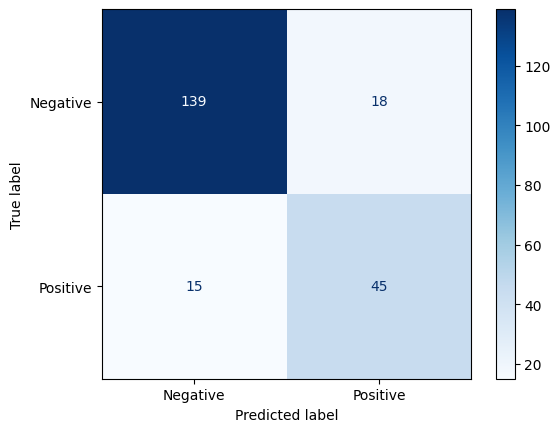

In [4]:

@torch.no_grad()
def evaluate_predictions_center():
    model.eval()
    feat_proj.eval()

    all_labels = []
    all_preds = []
    all_scores = []  # optional "probability-like" score for class 1

    C = center_loss_fn.centers.shape[0]  # num classes
    centers = center_loss_fn.centers     # (C, D)
    T = 1.0                              # temperature for softmax over -dist^2

    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # 1) get projected features
        feats = feat_proj(vit_cls_features(model, imgs))       # (N, D)

        # 2) distances to centers (L2)
        #    dists[n, c] = ||feat_n - center_c||
        dists = torch.cdist(feats, centers)                    # (N, C)

        # 3) nearest-center prediction
        preds = torch.argmin(dists, dim=1)                     # (N,)

        # 4) optional confidence: softmax over negative squared distances
        #    gives a normalized score per class; use score for class index 1 if binary
        scores = torch.softmax(-(dists ** 2) / T, dim=1)       # (N, C)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        # If binary, take score for class "1"; else keep the max score
        if C == 2:
            all_scores.extend(scores[:, 1].cpu().numpy())
        else:
            all_scores.extend(scores.max(dim=1).values.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_scores)


# ---- Generate reports ----
labels, preds, scores = evaluate_predictions_center()

print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
